<a href="https://www.kaggle.com/code/tridibraj/model-training-for-sign-recognition-digit?scriptVersionId=160989966" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
csv_directory = r'/kaggle/input/sign-language-digits/train'
labels_file = r'/kaggle/input/labels-for-numbers/labels.csv'

In [3]:
labels_df = pd.read_csv(labels_file, header=None)

# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv') and f != 'labels.csv']

In [4]:
features = []
labels = []

In [5]:
for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    data = pd.read_csv(file_path, header=None)
    labels_df.iloc[:, 0] = labels_df.iloc[:, 0].astype(str)

    # Append the data to the features list
    features.extend(data.values)

    # Extract the label based on the filename from the labels_df
    filename = os.path.splitext(csv_file)[0]
    label_row = labels_df[labels_df.iloc[:, 0] == filename].index
    if len(label_row) > 0:
        label = labels_df.iloc[label_row[0], 1]
        labels.extend([label] * len(data))
    else:
        print(f"Label not found for file: {csv_file}")

In [6]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=None)

# Reshape the features to match the input shape expected by the CNN
# Assuming the hand landmarks data has 63 columns (x1, y1, z1, ..., x21, y21, z21)
input_shape = (63, 1)  # (number of landmarks * number of coordinates, number of channels)
X_train_reshaped = np.reshape(X_train, (len(X_train), *input_shape))
X_test_reshaped = np.reshape(X_test, (len(X_test), *input_shape))


In [7]:
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [8]:
learning_rate = 0.001

# Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, batch_size=32, epochs=100, validation_data=(X_test_reshaped, y_test), verbose=1)

Epoch 1/100
52/52 [==============================] - 2s 15ms/step - loss: 2.1604 - accuracy: 0.3432 - val_loss: 1.7764 - val_accuracy: 0.4673
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 1.1294 - accuracy: 0.7059 - val_loss: 0.5472 - val_accuracy: 0.8959
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 0.4043 - accuracy: 0.8872 - val_loss: 0.2155 - val_accuracy: 0.9588
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 0.2061 - accuracy: 0.9557 - val_loss: 0.1291 - val_accuracy: 0.9758
Epoch 5/100
52/52 [==============================] - 0s 9ms/step - loss: 0.1373 - accuracy: 0.9666 - val_loss: 0.0749 - val_accuracy: 0.9903
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 0.0953 - accuracy: 0.9800 - val_loss: 0.0708 - val_accuracy: 0.9831
Epoch 7/100
52/52 [==============================] - 0s 9ms/step - loss: 0.0752 - accuracy: 0.9879 - val_loss: 0.0416 - val_accuracy: 0.9952
Epoch 8/100


In [9]:
import seaborn as sns
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
train_loss, train_acc = model.evaluate(X_train_reshaped, y_train)

# Generate predictions for the test set
y_pred_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(label_encoder.classes_)))
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
# Generate classification report
cls_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

13/13 [==============================] - 0s 3ms/step


In [10]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Calculate train and test accuracy standard deviation
train_acc_std = np.std(history.history['accuracy'])
test_acc_std = np.std(history.history['val_accuracy'])

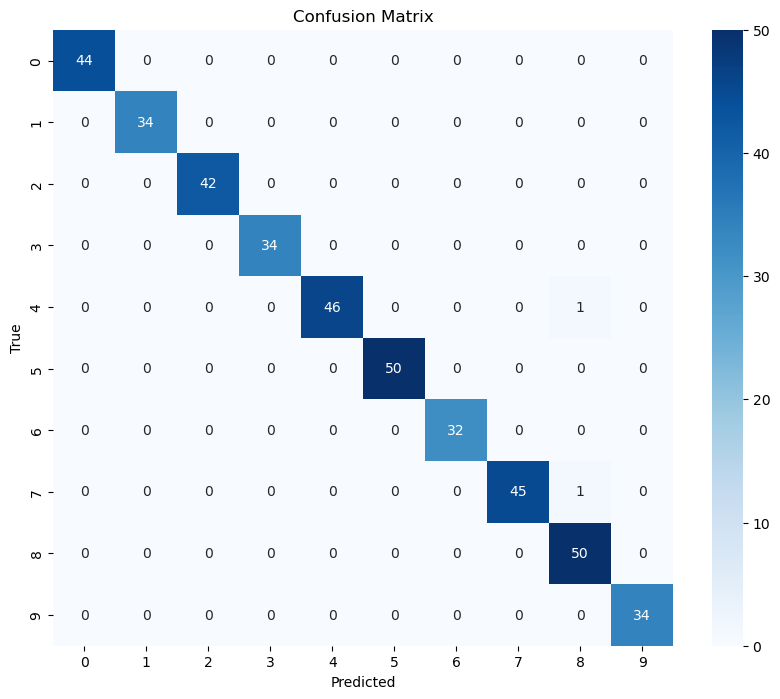

In [11]:
# Display the confusion matrix as a heatmap with colored formatting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join('/kaggle/working', 'Confusion Matrix.png'))
plt.show()


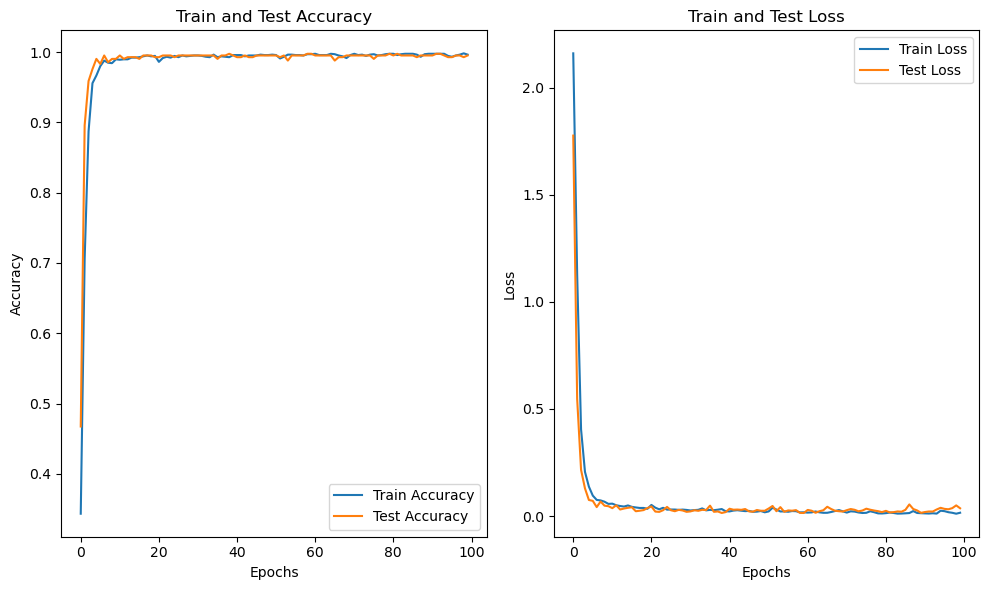

Train Loss: 0.012121171690523624
Train Accuracy: 0.9969678521156311
Train Accuracy Std: 0.07139852460502315
Test Loss: 0.036073632538318634
Test Accuracy: 0.9951573610305786
Test Accuracy Std: 0.05336475421721431
Confusion Matrix:
 [[44  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  1  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0]
 [ 0  0  0  0  0  0  0 45  1  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 34]]
Classification Report:
 {0: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 44}, 1: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, 2: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 42}, 3: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, 4: {'precision': 1.0, 'recall': 0.9787234042553191, 'f1-score': 0.989247311827957, 'support': 47}, 5: {'precision': 1.0, 'recall': 1

In [12]:
plt.figure(figsize=(10, 6))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()


plt.tight_layout()

plt.savefig(os.path.join('/kaggle/working', 'accuracy_loss_graphs.png'))  # Save the graphs
plt.show()

# Print the evaluation results
print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)
print('Train Accuracy Std:', train_acc_std)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Accuracy Std:', test_acc_std)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', cls_report)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1_score)


In [13]:
from keras.models import Sequential


model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model's weights to a .h5 file
model.save_weights("model_weights.h5")

In [14]:
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params = total_params - trainable_params
print('Total Parameters:', total_params)
print('Trainable Parameters:', trainable_params)
print('Non-trainable Parameters:', non_trainable_params)

Total Parameters: 138250
Trainable Parameters: 138250
Non-trainable Parameters: 0


In [15]:
import time

# Assuming you have a trained model named 'model' and test data 'X_test'
start_time = time.time()
y_pred = model.predict(X_test_reshaped)
end_time = time.time()

inference_time = end_time - start_time
print('Inference Time:', inference_time, 'seconds')

13/13 [==============================] - 0s 3ms/step
Inference Time: 0.13056302070617676 seconds


In [16]:
import os

# Specify the file path of the image to be deleted
image_path = '/kaggle/working/\kaggle\working\hand_sign_model.h5'

# Check if the file exists before attempting to delete
if os.path.exists(image_path):
    os.remove(image_path)
    print(f"{image_path} has been deleted.")
else:
    print(f"{image_path} does not exist.")

/kaggle/working/\kaggle\working\hand_sign_model.h5 does not exist.


In [17]:
from sklearn.model_selection import StratifiedKFold

# Parameters
n_splits = 5  # number of folds
epochs = 100
batch_size = 32

# Prepare the data
X = np.reshape(features, (len(features), *input_shape))
y = np.array(labels_encoded)

# Stratified K-Fold
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
train_accuracies = []
test_accuracies = []

for train, test in kfold.split(X, y):
    # Split data
    X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
    
    # Initialize model for each fold
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    
    # Evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Calculate mean and standard deviation for train and test accuracies
train_acc_mean = np.mean(train_accuracies)
train_acc_std = np.std(train_accuracies)
test_acc_mean = np.mean(test_accuracies)
test_acc_std = np.std(test_accuracies)

print(f'Train Accuracy Mean: {train_acc_mean:.4f}, Train Accuracy Std: {train_acc_std:.4f}')
print(f'Test Accuracy Mean: {test_acc_mean:.4f}, Test Accuracy Std: {test_acc_std:.4f}')


Epoch 1/100
52/52 [==============================] - 2s 8ms/step - loss: 2.1626 - accuracy: 0.2723
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 1.0999 - accuracy: 0.7047
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 0.3318 - accuracy: 0.9272
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 0.1584 - accuracy: 0.9654
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9745
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.9848
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0595 - accuracy: 0.9873
Epoch 8/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9903
Epoch 9/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.9879
Epoch 10/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0489 - accuracy: 0.9891
Epoch 11/